In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, Column, Integer, String, Float, Text, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
columns_m = inspector.get_columns('measurement')
for m in columns_m:
    print(m['name'], m["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns_s = inspector.get_columns('station')
for s in columns_s:
    print(s['name'], s["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
conn = engine.connect()

In [14]:
data_m = pd.read_sql("SELECT * FROM measurement", conn)
data_s = pd.read_sql("SELECT * FROM station", conn)

In [15]:
data_m.keys()

Index(['id', 'station', 'date', 'prcp', 'tobs'], dtype='object')

In [16]:
data_s.keys()

Index(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'], dtype='object')

# Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_end = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
date_end

'2017-08-23'

In [19]:
# Calculate the date 1 year ago from the last data point in the database
last_12 = dt.datetime.strptime(date_end, '%Y-%m-%d') - dt.timedelta(days=365)
last_12

datetime.datetime(2016, 8, 23, 0, 0)

In [24]:
# Perform a query to retrieve the data and precipitation scores
last_12_data = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_12).\
                    group_by(Measurement.date).all()
last_12_data

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05),
 ('2016-09-03', 0.254),
 ('2016-09-04', 0.276),
 ('2016-09-05', 0.08499999999999999),
 ('2016-09-06', 0.246),
 ('2016-09-07', 0.3333333333333333),
 ('2016-09-08', 0.07666666666666667),
 ('2016-09-09', 0.17833333333333332),
 ('2016-09-10', 0.27999999999999997),
 ('2016-09-11', 0.25),
 ('2016-09-12', 0.308),
 ('2016-09-13', 0.45166666666666666),
 ('2016-09-14', 2.3800000000000003),
 ('2016-09-15', 0.8266666666666667),
 ('2016-09-16', 0.11714285714285715),
 ('2016-09-17', 0.13599999999999998),
 ('2016-09-18', 0.10600000000000001),
 ('2016-09-19', 0.064),
 ('2016-09-20', 0.14714285714285716),
 ('2016-09-21', 0.19499999999999998),
 ('2016-09-22', 

In [28]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

data_df=pd.DataFrame(last_12_data, columns=['Date', 'Precipitation'])
data_index= data_df.set_index('Date')
data_sorted=data_index.sort_index()

data_sorted

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


In [ ]:
my_dict={}
for tup in last_12_data:
    my_dict[tup[0]]=tup[1]

<function matplotlib.pyplot.show(*args, **kw)>

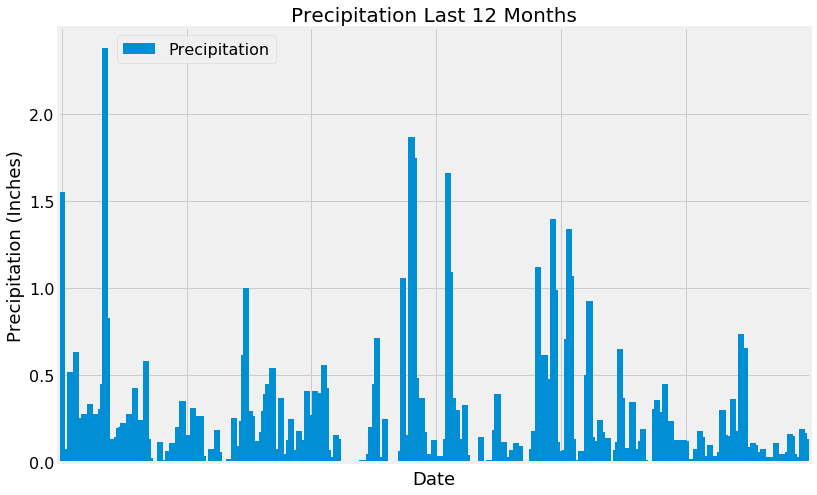

In [33]:
# Use Pandas Plotting with Matplotlib to plot the data

p_plot = data_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
p_plot.xaxis.set_major_formatter(plt.NullFormatter())
p_plot.tick_params(axis='y', labelsize=16)
p_plot.grid(True)
plt.legend(bbox_to_anchor=(.3,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.show

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [40]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(Station.name).count()
no_stations

9

In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [103]:
stations=[i[0] for i in station_count]


In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
busiest_station = station_count[0][0]
busiest_station_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter((Measurement.station)== busiest_station).all()
print(f'Minimum Temperature for most active station is {busiest_station_data[0][0]}')
print(f'Maximum Temperature for most active station is {busiest_station_data[0][1]}')
print(f'Average Temperature for most active station is {busiest_station_data[0][2]}')

Minimum Temperature for most active station is 54.0
Maximum Temperature for most active station is 85.0
Average Temperature for most active station is 71.66378066378067


In [118]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
highest_obs = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.date >= last_12).\
filter(Measurement.station == busiest_station).order_by((Measurement.date).desc()).all()
highest_obs

[('USC00519281', 79.0),
 ('USC00519281', 76.0),
 ('USC00519281', 76.0),
 ('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 83.0),
 ('USC00519281', 82.0),
 ('USC00519281', 77.0),
 ('USC00519281', 76.0),
 ('USC00519281', 81.0),
 ('USC00519281', 82.0),
 ('USC00519281', 81.0),
 ('USC00519281', 76.0),
 ('USC00519281', 75.0),
 ('USC00519281', 77.0),
 ('USC00519281', 75.0),
 ('USC00519281', 82.0),
 ('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 77.0),
 ('USC00519281', 76.0),
 ('USC00519281', 76.0),
 ('USC00519281', 76.0),
 ('USC00519281', 80.0),
 ('USC00519281', 80.0),
 ('USC00519281', 76.0),
 ('USC00519281', 74.0),
 ('USC00519281', 74.0),
 ('USC00519281', 72.0),
 ('USC00519281', 69.0),
 ('USC00519281', 78.0),
 ('USC00519281', 78.0),
 ('USC00519281', 75.0),
 ('USC00519281', 74.0),
 ('USC00519281', 77.0),
 ('USC00519281', 78.0),
 ('USC00519281', 76.0),
 ('USC00519281', 81.0),
 ('USC00519281', 79.0),
 ('USC00519281', 76.0),
 ('USC00519281',

In [72]:
obs_df = pd.DataFrame(highest_obs)
obs_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


In [77]:
index_change = obs_df.set_index('station')
index_change

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0
...,...
USC00519281,77.0
USC00519281,77.0
USC00519281,76.0


<function matplotlib.pyplot.show(*args, **kw)>

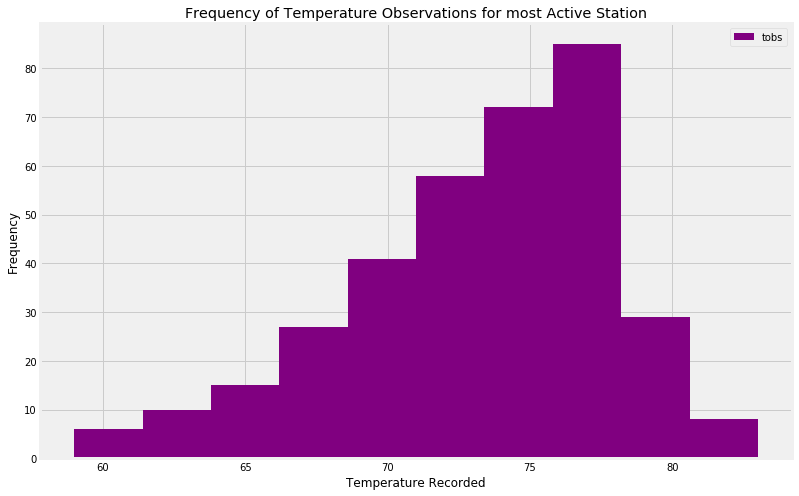

In [82]:
index_change.plot.hist(by='station', bins=10, figsize=(12,8), color='purple')
plt.title("Frequency of Temperature Observations for most Active Station")
plt.xlabel("Temperature Recorded")

plt.legend
plt.show

In [83]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [87]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps=calc_temps('2016-02-28', '2016-03-05')
temps=temps[0]

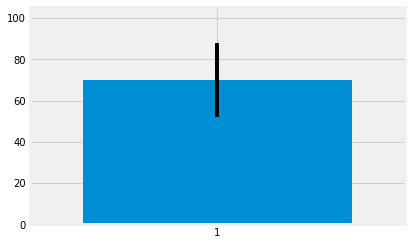

In [98]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig,ax=plt.subplots()
ax.bar(x=1,height = temps[1], yerr=temps[0]-temps[2])
ax.set(xticks=[1])
ax.margins(.2,.2)

In [115]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def trip_info(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    sel=[Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
    return session.query(*sel).filter(Measurement.station==Station.station).filter(Measurement.date>start_date).filter(Measurement.date<end_date). \
group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()    
   # return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    #    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))

#for station in stations:
 #   session.query

In [116]:
print(trip_info('2012-02-28', '2012-03-05'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.79), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.55), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.9200000000000004), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.21000000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.09999999999999999), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.08), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.060000000000000005), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


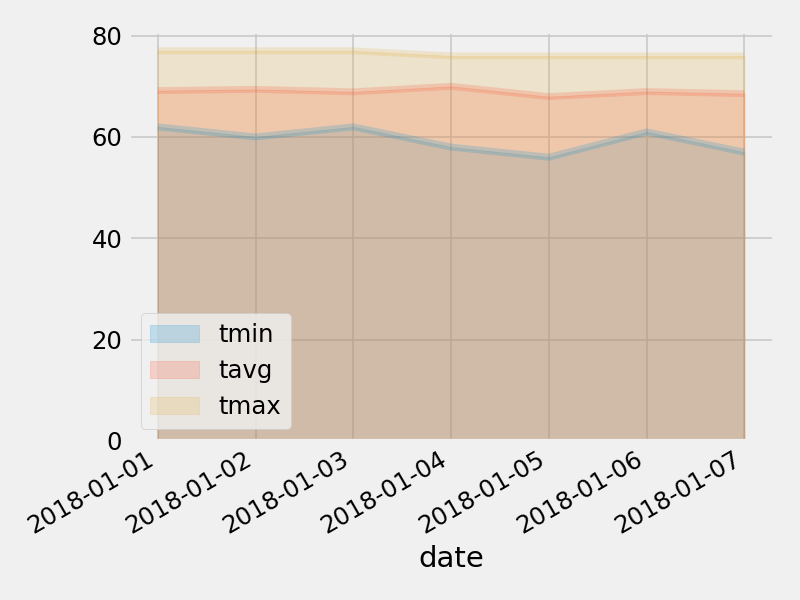

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
